<a href="https://colab.research.google.com/github/realmialam/Plant-Leaf-Disease-Detection/blob/main/Plant_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Plant Disease**

---



Plant gets attacked by disease. Prime attack of disease is on leaf of the plant.

Here, we are developing a model which will detect the disease by which plant is effected.


First we **mount** the Google Drive at /content/drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fetch Dataset


First we download the data set from **Google Drive** then we unzip the file

In [ ]:
# # Download a file based on its file ID.
# file_id = '18DbC6Xj4NP-hLzI14WuMaAEyq482vNfn'

# # Download dataset
# !gdown https://drive.google.com/uc?id={file_id}

# # Unzip the downloaded file
# !unzip -q PlantVillage.zip

# Install **keras** and **tensorflow**

In [ ]:
!pip install q keras==2.3.0
!pip uninstall tensorflow -y
!pip install  tensorflow==2.2.0

Uninstalling tensorflow-2.2.0:
  Successfully uninstalled tensorflow-2.2.0
  Using cached https://files.pythonhosted.org/packages/4c/1a/0d79814736cfecc825ab8094b39648cc9c46af7af1bae839928acb73b4dd/tensorflow-2.2.0-cp37-cp37m-manylinux2010_x86_64.whl


# Import Libraries


Importing necessary libraries and modules

In [60]:
import numpy as np
import pickle
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Load Dataset

Initialize

*   DEFAULT_IMAGE_SIZE
*   N_IMAGES
*   root_dir
*   train_dir
*   val_dir

In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Number of images used to train the model
N_IMAGES = 100

# Path to the dataset folder
root_dir = "/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage"

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')

# Image to np_array

We use the function `convert_image_to_array` to resize an image to the size `DEFAULT_IMAGE_SIZE` we defined above.

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

* image_list
* label_list

Here, we load the training data images by traversing through all the folders and converting all the images and labels into separate lists respectively.

Also because of computational limitation, we take only

*   N_IMAGES=100

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:N_IMAGES]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            image_list.append(convert_image_to_array(image_directory))
            label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print()

# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Tomato___Tomato_Yellow_Leaf_Curl_Virus ...
[INFO] Processing Tomato___Target_Spot ...
[INFO] Processing Tomato___Late_blight ...
[INFO] Processing Tomato___Spider_mites Two-spotted_spider_mite ...
[INFO] Processing Tomato___Leaf_Mold ...
[INFO] Processing Tomato___Tomato_mosaic_virus ...
[INFO] Processing Tomato___Septoria_leaf_spot ...
[INFO] Processing Tomato___Early_blight ...
[INFO] Processing Tomato___healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Squash___Powdery_mildew ...
[INFO] Processing Tomato___Bacterial_spot ...
[INFO] Processing Soybean___healthy ...
[INFO] Processing Strawberry___healthy ...
[INFO] Processing Strawberry___Leaf_scorch ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Raspberry___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Pepper,_bell___healthy ...
[INFO] Processing Orange___Haunglongbing_(Citrus_greening) ...
[INFO] Processing Peach___Bacterial_

# One hot Encoding

Examine the labels/classes in the training dataset.

we create a ***plant_disease_label_transform.pkl*** and dump into Google Drive

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)


# label path
label_path = "/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model"
label_file = 'plant_disease_label_transform.pkl'
pickle.dump(label_binarizer,open(f'{label_path}/{label_file}', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  39


# Augment and Split Dataset

Using `ImageDataGenerator` to augment data by performing various operations on the training images.

In [ ]:
augment = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                             height_shift_range=0.1, shear_range=0.2, 
                             zoom_range=0.2, horizontal_flip=True, 
                             fill_mode="nearest")

Splitting the data into training and test sets for validation purpose.

In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Splitting data to train and test...


# Build Model


Defining the hyperparameters of the plant disease classification model.

In [ ]:
EPOCHS = 15
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

Creating a sequential model and adding Convolutional, Normalization, Pooling, Dropout and Activation layers at the appropriate positions.

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

# Train Model


We initialize Adam optimizer with learning rate and decay parameters. 

Also, we choose the type of loss and metrics for the model and compile it for training.

we also select other metrics for analyis

In [ ]:
# Initialize optimizer
opt = Adam(lr=LR, decay=LR / EPOCHS)

# Metrics
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
true_positive = tf.keras.metrics.TruePositives()
true_negative = tf.keras.metrics.TrueNegatives()
false_positive = tf.keras.metrics.FalsePositives()
false_negative = tf.keras.metrics.FalseNegatives()

# Compile model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", "mse", "mean_absolute_error", precision, recall, true_positive, true_negative, false_positive, false_negative])

# Train model
print("[INFO] Training network...")
history = model.fit_generator(augment.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_test, y_test),
                              steps_per_epoch=len(x_train) // BATCH_SIZE,
                              epochs=EPOCHS, 
                              verbose=1)

[INFO] Training network...
Epoch 1/15
97/97 [==============================] - 865s 9s/step - loss: 0.0981 - accuracy: 0.9736 - mse: 0.0227 - mean_absolute_error: 0.0398 - precision: 0.3638 - recall: 0.1111 - true_positives: 214.1856 - true_negatives: 58766.5977 - false_positives: 290.8866 - false_negatives: 1339.9587 - val_loss: 0.3418 - val_accuracy: 0.9499 - val_mse: 0.0436 - val_mean_absolute_error: 0.0500 - val_precision: 0.3547 - val_recall: 0.1588 - val_true_positives: 554.2000 - val_true_negatives: 132081.3125 - val_false_positives: 1040.2800 - val_false_negatives: 2949.0000
Epoch 2/15
97/97 [==============================] - 855s 9s/step - loss: 0.0773 - accuracy: 0.9763 - mse: 0.0191 - mean_absolute_error: 0.0336 - precision: 0.3613 - recall: 0.1853 - true_positives: 1024.8969 - true_negatives: 204437.5469 - false_positives: 1760.6495 - false_negatives: 4401.3711 - val_loss: 0.3515 - val_accuracy: 0.9554 - val_mse: 0.0390 - val_mean_absolute_error: 0.0491 - val_precision: 0.3

# Evaluate Model

Comparing the accuracy and loss by plotting the graph for training and validation.

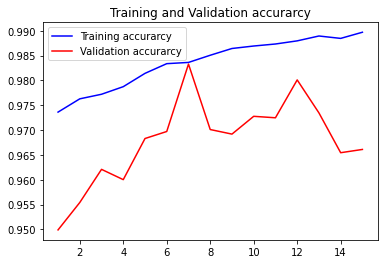

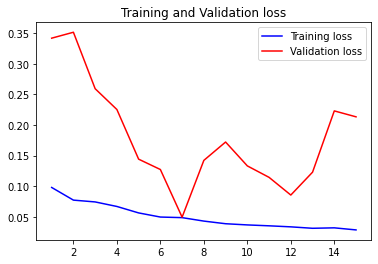

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()

# Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Evaluating model accuracy by using the `evaluate` method

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
780/780 [==============================] - 56s 71ms/step
Test Accuracy: 96.61076664924622


# **Analysis of Metrics**

 **1. Mean Squared Error**

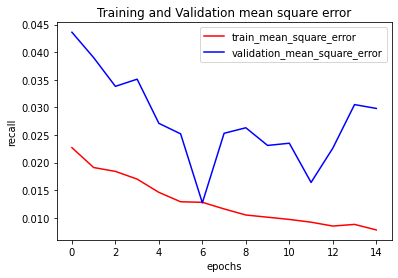

In [61]:
# train mean squared error
mse1 = np.array([0.0227, 0.0191, 0.0184, 0.0170, 0.0146, 0.0129, 0.0128, 0.0116, 0.0105, 0.0101, 0.0097, 0.0092, 0.0085, 0.0088, 0.0078])
# validation mean square error
mse2 = np.array([0.0436, 0.0390, 0.0338, 0.0351, 0.0271, 0.0252, 0.0127, 0.0253, 0.0263, 0.0231, 0.0235, 0.0164, 0.0226, 0.0305, 0.0298])

# plotting
plt.plot(mse1, color = 'r', label = 'train_mean_square_error')
plt.plot(mse2, color = 'b', label = 'validation_mean_square_error')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('recall')
plt.title('Training and Validation mean square error')
plt.show()


**2. Mean Absolute Error**

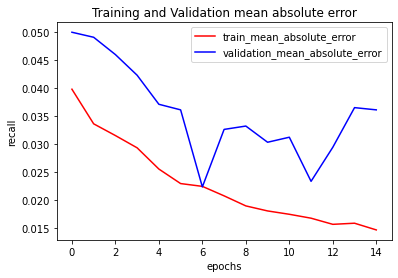

In [62]:
# train mean absolute error
mae1 = np.array([0.0398, 0.0336, 0.0315, 0.0293, 0.0255, 0.0229, 0.0224, 0.0207, 0.0189, 0.0180, 0.0174, 0.0167, 0.0156, 0.0158, 0.0146])
# validation mean absolute error
mae2 = np.array([0.0500, 0.0491, 0.0460, 0.0423, 0.0371, 0.0361, 0.0223, 0.0326, 0.0332, 0.0303, 0.0312, 0.0233, 0.0294, 0.0365, 0.0361])

# plotting
plt.plot(mae1, color = 'r', label = 'train_mean_absolute_error')
plt.plot(mae2, color = 'b', label = 'validation_mean_absolute_error')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('recall')
plt.title('Training and Validation mean absolute error')
plt.show()

**3. Precision**

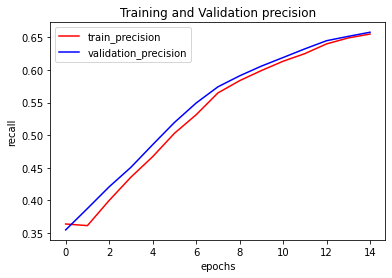

In [63]:
# train precision
pre1 = np.array([0.3638, 0.3613, 0.3999, 0.4356, 0.4670, 0.5028, 0.5313, 0.5647, 0.5836, 0.5991, 0.6134, 0.6251, 0.6400, 0.6492, 0.6551])
# validation precision
pre2 = np.array([0.3547, 0.3875, 0.4208, 0.4507, 0.4854, 0.5194, 0.5493, 0.5741, 0.5910, 0.6059, 0.6191, 0.6324, 0.6449, 0.6516, 0.6579])


# plotting
plt.plot(pre1, color = 'r', label = 'train_precision')
plt.plot(pre2, color = 'b', label = 'validation_precision')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('recall')
plt.title('Training and Validation precision')
plt.show()

**4. Recall**

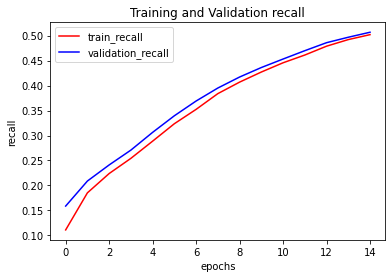

In [64]:
# train recall
rec1 = np.array([0.1111, 0.1853, 0.2239, 0.2543, 0.2887, 0.3236, 0.3523, 0.3838, 0.4068, 0.4270, 0.4455, 0.4610, 0.4787, 0.4919, 0.5018])
# validation recall
rec2 = np.array([0.1588, 0.2089, 0.2411, 0.2708, 0.3063, 0.3395, 0.3690, 0.3950, 0.4170, 0.4360, 0.4530, 0.4697, 0.4857, 0.4966, 0.5066])

# plotting
plt.plot(rec1, color = 'r', label = 'train_recall')
plt.plot(rec2, color = 'b', label = 'validation_recall')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('recall')
plt.title('Training and Validation recall')
plt.show()

# Save Model

In [ ]:
# Dump pickle file of the model
print("[INFO] Saving model...")

# model path
model_path = "/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model"
model_file = 'plant_disease_classification_model.pkl'
pickle.dump(model,open(f'{model_path}/{model_file}', 'wb'))

[INFO] Saving model...


In [ ]:
# Dump pickle file of the labels
print("[INFO] Saving label transform...")
filename = f'{label_path}/{label_file}'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


# Save whole model

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model"
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

# Save model in HDF5 Format

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
print("[INFO] Saving model in HDF5 File...")
model_path = "/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model"
model_file = 'my_model.h5'

model.save(f'{model_path}/{model_file}')

[INFO] Saving model in HDF5 File...


# Test Model


We write the following `predict_disease` function to predict the class or disease of a plant image. 

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict_classes(np_image)
    print((image_labels.classes_[result][0]))

# Print all the metrics

In [ ]:
# print all the metrics
print(epochs)

# accuracy
acc = history.history['accuracy']
print(acc)
val_acc = history.history['val_accuracy']
print(val_acc)

# loss
loss = history.history['loss']
print(loss)
val_loss = history.history['val_loss']
print(val_loss)

# mean squared error
mse = history.history['mse']
print(mse)
val_mse = history.history['val_mse']
print(val_mse)

# mean absolute error
absolute = history.history['mean_absolute_error']
print(absolute)
val_absolute = history.history['val_mean_absolute_error']
print(val_absolute)

# precision
precision = history.history['precision']
print(precision)
val_precision = history.history['val_precision']
print(val_precision)

# recall
recall = history.history['recall']
print(recall)
val_recall = history.history['val_recall']
print(val_recall)

# true positives
true_pos = history.history['true_positives']
print(true_pos)
val_true_pos = history.history['val_true_positives']
print(val_true_pos)

# true negatives
true_neg = history.history['true_negatives']
print(true_neg)
val_true_neg = history.history['val_true_negatives']
print(val_true_neg)

# false positives
false_pos = history.history['false_positives']
print(false_pos)
val_false_pos = history.history['val_false_positives']
print(val_false_pos)

# false negatives
false_neg = history.history['false_negatives']
print(false_neg)
val_false_neg = history.history['val_false_negatives']
print(val_false_neg)






range(1, 16)
[0.9736277, 0.9763014, 0.97722316, 0.9787509, 0.98143315, 0.9833849, 0.9836342, 0.98507893, 0.9864408, 0.9869388, 0.9873456, 0.987977, 0.9889561, 0.98847383, 0.9897127]
[0.9499014616012573, 0.9554240107536316, 0.9620973467826843, 0.9600263833999634, 0.9683102965354919, 0.9697238802909851, 0.9833004474639893, 0.9701182842254639, 0.9691979885101318, 0.9727811217308044, 0.9724852442741394, 0.9801117777824402, 0.9734714031219482, 0.9654503464698792, 0.9661076664924622]
[0.09803174436092377, 0.07735733023888089, 0.07439958196075469, 0.06699709215930089, 0.05645962495723537, 0.04972268668017857, 0.04875773716467032, 0.04310994084750741, 0.03880280321898238, 0.03686233681332262, 0.03540033684956595, 0.03371196236326287, 0.03136693225386217, 0.032095546688651666, 0.02870315300792919]
[0.34177949199309715, 0.35146258228864424, 0.25926686357229184, 0.22530125280221303, 0.14422894769754166, 0.1273367335398992, 0.04949876161722037, 0.14224690321164254, 0.17221018717839168, 0.133233413

For testing purposes, we randomly choose images from the dataset and try predicting class or disease of the plant image.

Apple___Apple_scab


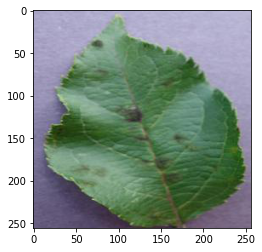

In [ ]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG')

Potato___Early_blight


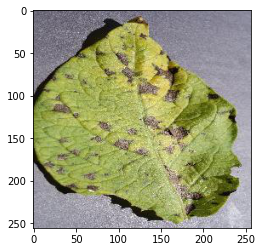

In [ ]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f8904670290f___RS_Early.B 7051.JPG')

Tomato___Tomato_mosaic_virus


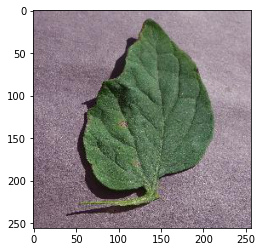

In [ ]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Tomato___Target_Spot/1006b3dd-22d8-41b8-b83d-08bf189fcdaa___Com.G_TgS_FL 8118.JPG')

Orange___Haunglongbing_(Citrus_greening)


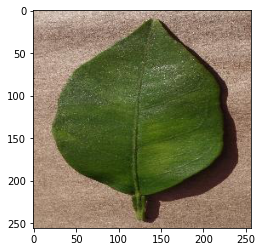

In [ ]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/02459e0c-a189-4dc9-a0dc-0548e36d0efb___CREC_HLB 5714.JPG')

# Reuse Model

We download the trained model and label transform saved in the Google Drive.

In [ ]:
# # Download the trained model file based on its file ID.
# file_id = '1E5jNzpM__7z67GRl1cbhHK71yKcPa8wl'
# !gdown https://drive.google.com/uc?id={file_id}

# # Download the labels file based on its file ID.
# file_id = '1WsgEd3TG33Vj_9AAAT_WfJe_AqsuC9uu'
# !gdown https://drive.google.com/uc?id={file_id}

Importing necessary libraries and modules required to build the classification model.

In [3]:
import numpy as np
import pickle
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## Load Trained Model and Label

Load the trained model and its labels for prediction.

In [13]:
# Load model

model_path = "/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model"
model_file = 'my_model.h5'
filename = f'{model_path}/{model_file}'
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(filename)

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

In [41]:
# Load labels

!ls
%cd /content/drive/MyDrive/Colab\ Notebooks/CNN/CNN_Trained_Model
!pwd
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

# move to content directory
%cd ~
%cd /content/
!pwd

/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model
/content/drive/MyDrive/Colab Notebooks/CNN/CNN_Trained_Model
/root
/content
/content


We use the `convert_image_to_array` function to resize an image and `predict_disease` function to predict the class or disease of a plant image which we have implemented earlier

We just need to provide the complete path to the image and it displays the image along with its prediction class or plant disease.

In [45]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)   
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = new_model.predict_classes(np_image)
    print(result)
    print((image_labels.classes_[result][0]))

# Prediction

Predict disease of any plant image.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[36]
Tomato___Tomato_mosaic_virus


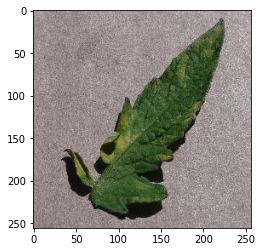

In [46]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Tomato___Leaf_Mold/05138150-866c-460e-a252-19d269a81d4d___Crnl_L.Mold 6745.JPG')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[38]
background


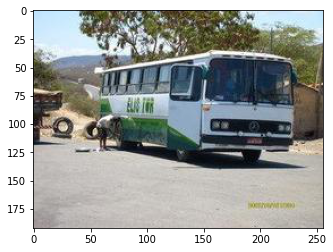

In [47]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/background/0004498.jpg')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[36]
Tomato___Tomato_mosaic_virus


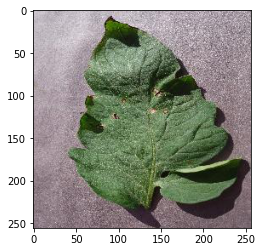

In [52]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Tomato___Target_Spot/13358e3d-69ae-40e0-9b04-6d3237ffeded___Com.G_TgS_FL 0993.JPG')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[15]
Orange___Haunglongbing_(Citrus_greening)


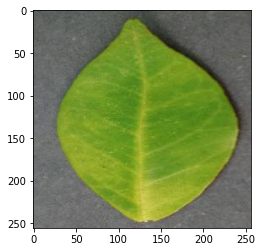

In [56]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Orange___Haunglongbing_(Citrus_greening)/1585c9bc-90a2-497f-89af-ad4c91dde2e4___UF.Citrus_HLB_Lab 1077.JPG')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[8]
Corn_(maize)___Common_rust_


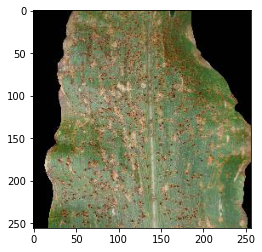

In [59]:
predict_disease('/content/drive/MyDrive/Colab Notebooks/CNN/PlantVillage/val/Corn_(maize)___Common_rust_/RS_Rust 1637.JPG')